In [1]:
# Python Library Imports
import tensorflow as tf

import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import Dense, Activation, Dropout, Flatten

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
from keras.models import Sequential
from keras.layers import Dense , Activation , Dropout ,Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.metrics import categorical_accuracy
from keras.models import model_from_json
from keras.callbacks import ModelCheckpoint
from keras.optimizers import *
from keras.layers.normalization import BatchNormalization

In [3]:

# get the data
filename = 'Data/data.csv'
label_map = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
names=['emotion','pixels','usage']
df=pd.read_csv(filename,names=names, na_filter=False)
im=df['pixels']
df.head(10)

,emotion,pixels,usage
0,emotion,pixels,Usage
1,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
2,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
3,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
4,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
5,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
6,2,55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...,Training
7,4,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...,Training
8,3,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...,Training
9,3,85 84 90 121 101 102 133 153 153 169 177 189 1...,Training


In [4]:
def getData(filname):
    # images are 48x48 : black & white?
    # N = 35887
    Y = []
    X = []
    first = True
    for line in open(filname):
        if first:
            first = False
        else:
            row = line.split(',')
            Y.append(int(row[0]))
            X.append([int(p) for p in row[1].split()])

    X, Y = np.array(X) / 255.0, np.array(Y)
    return X, Y

In [5]:
X, Y = getData(filename)
num_class = len(set(Y))
print(num_class)

7


In [6]:
# keras with tensorflow backend
N, D = X.shape
X = X.reshape(N, 48, 48, 1)

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=0)
y_train = (np.arange(num_class) == y_train[:, None]).astype(np.float32)
y_test = (np.arange(num_class) == y_test[:, None]).astype(np.float32)

In [8]:
def my_model():
    model = Sequential()
    input_shape = (48,48,1) # input image, 48 pixel by 48 pixel, black and white?
    model.add(Conv2D(64, (5, 5), input_shape=input_shape,activation='relu', padding='same')) # Applying 64 kernels, 5 by 5
    # output will be 64 feature maps of 
    model.add(Conv2D(64, (5, 5), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2))) # Max pooling

    model.add(Conv2D(128, (5, 5),activation='relu',padding='same'))
    model.add(Conv2D(128, (5, 5),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(256, (3, 3),activation='relu',padding='same'))
    model.add(Conv2D(256, (3, 3),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten()) # Flattens multi-dimenional array to 1d array
    model.add(Dense(128))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(7))
    model.add(Activation('softmax'))
    
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer='adam')
    # UNCOMMENT THIS TO VIEW THE ARCHITECTURE
    #model.summary()
    
    return model
model=my_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 64)        1664      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 64)        102464    
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 128)       204928    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 128)       409728    
_________________________________________________________________
batch_normalization_2 (Batch (None, 24, 24, 128)      

In [9]:
path_model='model_filter.h5' # save model at this location after each epoch
K.tensorflow_backend.clear_session() # destroys the current graph and builds a new one
model=my_model() # create the model
K.set_value(model.optimizer.lr,1e-3) # set the learning rate
# fit the model
h=model.fit(x=X_train,     
            y=y_train, 
            batch_size=64, 
            epochs=20, 
            verbose=1, 
            validation_data=(X_test,y_test),
            shuffle=True,
            callbacks=[
                ModelCheckpoint(filepath=path_model),
            ]
            )

Train on 32298 samples, validate on 3589 samples
Epoch 1/20
32298/32298 [==============================] - 671s 21ms/step - loss: 1.6532 - accuracy: 0.3625 - val_loss: 1.6081 - val_accuracy: 0.3564
Epoch 2/20
32298/32298 [==============================] - 685s 21ms/step - loss: 1.2827 - accuracy: 0.5126 - val_loss: 1.2708 - val_accuracy: 0.4985
Epoch 3/20
32298/32298 [==============================] - 692s 21ms/step - loss: 1.1041 - accuracy: 0.5832 - val_loss: 1.3423 - val_accuracy: 0.4843
Epoch 4/20
32298/32298 [==============================] - 638s 20ms/step - loss: 0.9866 - accuracy: 0.6317 - val_loss: 1.1654 - val_accuracy: 0.5570
Epoch 5/20
32298/32298 [==============================] - 697s 22ms/step - loss: 0.8677 - accuracy: 0.6809 - val_loss: 1.0680 - val_accuracy: 0.6018
Epoch 6/20
32298/32298 [==============================] - 714s 22ms/step - loss: 0.7271 - accuracy: 0.7340 - val_loss: 1.2800 - val_accuracy: 0.5492
Epoch 7/20
32298/32298 [==============================] -

In [10]:
objects = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
y_pos = np.arange(len(objects))
print(y_pos)

[0 1 2 3 4 5 6]


In [11]:
def emotion_analysis(emotions):
    objects = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
    y_pos = np.arange(len(objects))
    plt.bar(y_pos, emotions, align='center', alpha=0.9)
    plt.tick_params(axis='x', which='both', pad=10,width=4,length=10)
    plt.xticks(y_pos, objects)
    plt.ylabel('percentage')
    plt.title('emotion')
    
plt.show()

In [14]:
y_pred=model.predict(X_test)
print(y_pred)
y_test.shape

[[1.7554736e-05 4.2761889e-07 8.2502929e-09 ... 1.9200590e-08
  9.6819645e-07 7.3296273e-01]
 [5.6635408e-06 3.7067063e-10 1.6977164e-03 ... 9.9828547e-01
  1.1042927e-05 4.4434731e-08]
 [5.6719318e-07 2.0747073e-09 4.8424266e-03 ... 6.3297416e-11
  9.9396110e-01 8.1569259e-04]
 ...
 [2.2163898e-04 8.3969690e-06 1.1386280e-02 ... 2.6061962e-04
  4.0615955e-03 4.4279909e-01]
 [2.7270930e-02 2.9897995e-04 3.3977944e-02 ... 4.5421877e-04
  8.7788534e-01 5.9582517e-02]
 [5.2345797e-07 2.2322418e-08 9.9988890e-01 ... 7.6539100e-06
  3.8359458e-06 9.9015102e-05]]


(3589, 7)

In [13]:
# save preprocessing objects and RF algorithm
#joblib.dump(train_mode, "./train_mode.joblib", compress=True)

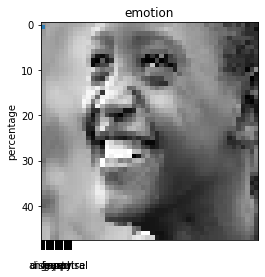

Expression Prediction: angry


In [35]:
from skimage import io
img = image.load_img('Data/h.jpeg', grayscale=True, target_size=(48, 48))
show_img=image.load_img('Data/h.jpeg', grayscale=True, target_size=(48, 48))
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = model.predict(x)
#print(custom[0])
emotion_analysis(custom[0])

x = np.array(x, 'float32')
x = x.reshape([48, 48]);

plt.gray()
plt.imshow(show_img)
plt.show()

m=0.000000000000000000001
a=custom[0]
for i in range(0,len(a)):
    if a[i]>m:
        m=a[i]
        ind=i
        
print('Expression Prediction:',objects[ind])

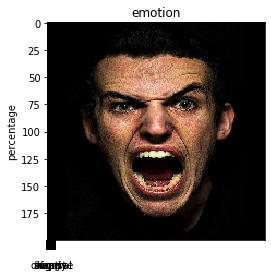

Expression Prediction: angry


In [25]:
from skimage import io
img = image.load_img('Data/anger.jpeg', grayscale=True, target_size=(48, 48))
show_img=image.load_img('Data/anger.jpeg', grayscale=False, target_size=(200, 200))
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = model.predict(x)
#print(custom[0])
emotion_analysis(custom[0])

x = np.array(x, 'float32')
x = x.reshape([48, 48]);

plt.gray()
plt.imshow(show_img)
plt.show()

m=0.000000000000000000001
a=custom[0]
for i in range(0,len(a)):
    if a[i]>m:
        m=a[i]
        ind=i
        
print('Expression Prediction:',objects[ind])

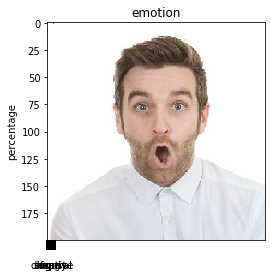

Expression Prediction: surprise


In [26]:
from skimage import io
img = image.load_img('Data/suprise.jpeg', grayscale=True, target_size=(48, 48))
show_img=image.load_img('Data/suprise.jpeg', grayscale=False, target_size=(200, 200))
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = model.predict(x)
#print(custom[0])
emotion_analysis(custom[0])

x = np.array(x, 'float32')
x = x.reshape([48, 48]);

plt.gray()
plt.imshow(show_img)
plt.show()

m=0.000000000000000000001
a=custom[0]
for i in range(0,len(a)):
    if a[i]>m:
        m=a[i]
        ind=i
        
print('Expression Prediction:',objects[ind])

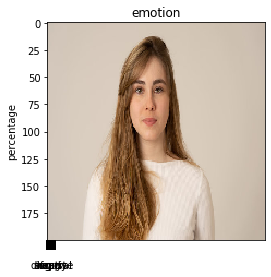

Expression Prediction: fear


In [28]:
from skimage import io
img = image.load_img('Data/neutral.jpeg', grayscale=True, target_size=(48, 48))
show_img=image.load_img('Data/neutral.jpeg', grayscale=False, target_size=(200, 200))
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = model.predict(x)
#print(custom[0])
emotion_analysis(custom[0])

x = np.array(x, 'float32')
x = x.reshape([48, 48]);

plt.gray()
plt.imshow(show_img)
plt.show()

m=0.000000000000000000001
a=custom[0]
for i in range(0,len(a)):
    if a[i]>m:
        m=a[i]
        ind=i
        
print('Expression Prediction:',objects[ind])